# **Experiment 1: Value Model Measurements**

1. **Workload Latencies**: Measure the response times of the system.
2. **Latency Prediction Q-Errors**: Evaluate the accuracy of the system's latency prediction model by calculating Q-Errors, which quantify the deviation between predicted and actual latencies.
3. **Inference Times**: Analyze the time taken for the system to process and generate predictions, providing insights into its computational efficiency.

### **Hardware Used**

| **System**                                      | **CPU**                                       | **RAM**                                      | **Storage**                                   | **GPU**                                          | **Platform**                                     |
|-------------------------------------------------|-----------------------------------------------|----------------------------------------------|-----------------------------------------------|-------------------------------------------------|-------------------------------------------------|
| **BAO**                                         | Intel Xeon Gold 6230                         | 15GB (VM) + 256GB (CPU)                      | Not specified                                 | Tesla T4 GPU                                     | Google Cloud Platform (N1-4 VM)                 |
| **LOGER**                                       | 2× Intel Xeon Gold                           | 256GB                                        | Not specified                                 | NVIDIA RTX 3090                                  | Physical Server                                 |
| **BALSA**                                       | Microsoft Azure VMs (8 cores)                | 64GB                                         | SSD                                           | NVIDIA Tesla M60 GPU                             | Microsoft Azure                                 |
| **FASTgres**                                    | Intel Xeon Gold 6216 (12 cores)              | 92GB                                         | 1.8 TiB storage                               | Not specified                                    | Physical Server                                 |
| **train-server (Hosts PostgreSQL)**             | QEMU Virtual CPU version 2.5                 | 110GB                                        | 2.0 TiB SSD                                   | None                                            | Physical Server                                 |
| **train-gpu-server (Hosts the optimizers)**     | Intel(R) Xeon(R) Gold 5318Y                  | 377GB                                        | 1.4 TiB SSD                                   | NVIDIA RTX A6000                                  | Physical Server                                 |

### **PostgreSQL Configurations**

| **PostgreSQL Config Parameter**  | **Description** | **Default Values** | **JOB** | **Bao** | **Balsa** | **LOGER** | **Our Framework** |
|----------------------------------|----------------|------------------|-------------|-------------|-----------------------|-------------|----------------|
| **Join Order** |  |  |  |  |  |  |  |
| geqo_threshold | Sets the threshold for Genetic Query Optimizer (GEQO) to be used | 12 | 18 |  |  | 2 or 1,024 |  |
| geqo | Enables or disables GEQO, which helps optimize complex queries | on |  |  | off | off | off |
| **Working Memory** |  |  |  |  |  |  |  |
| work_mem | Memory allocated for each query operation (e.g., sorting, hashing) | 4 MB | 2 GB |  | 4 GB | | 4 GB |
| shared_buffers | Memory used for PostgreSQL's buffer cache to reduce disk I/O | 128 MB | 4 GB | 4 GB | 32 GB | 64 GB | 32 GB |
| temp_buffers | Memory allocated for temporary tables during a session | 8 MB |  |  | 32 GB |  | 32 GB |
| effective_cache_size | Estimated memory available for caching disk pages | 4 GB | 32 GB |  |  |  | 64 GB |
| **Parallelization** |  |  |  |  |  |  |  |
| max_parallel_workers | Maximum number of parallel workers allowed | 8 |  |  |  | 1 | 8 |
| max_parallel_workers_per_gather | Maximum parallel workers per `Gather` node in a query plan | 8 |  |  |  | 1 | 8 |
| max_worker_processes | Maximum background worker processes allowed | 2 |  |  | 8 |  | 8 |
| **Scan Types** |  |  |  |  |  |  |  |
| enable_bitmapscan | Enables bitmap scans for efficient index-based retrieval | on |  | | off |  | on |
| enable_tidscan | Enables TID scans, which use tuple IDs for direct row lookups | on |  |  | off |  | on |


## **Benchmarks Used**

### **1. JOB and its Variants**

#### **Join Order Benchmark (Default)**

- Evaluates the efficiency of database query optimizers, focusing on join order optimization and cardinality estimation accuracy.
- 21 Tables, 6 Columns per Table on Average, 3.6 GB in size, 113 Queries in total, 8 average Joins per query

## **2. TPC-H and Its Variants**  

### **TPC-H-NO-NESTED-QUERIES**  
- Uses **templates 3, 5, 12, and 14** for training and **template 10** for testing, with **10 queries per template**.  
- Excludes queries containing **nested subqueries** in either the **FROM** or **WHERE** clause.  
- Templates **7, 8, and 13** are excluded due to their reliance on these nested structures, which **LOGER** and **FASTgres** cannot process.  
- **Example of Banned Queries:**  

  **1. Nested FROM Clause (Disallowed)**  
  ```sql
  SELECT o_orderkey, revenue
  FROM (
      SELECT l_orderkey AS o_orderkey, SUM(l_extendedprice) AS revenue
      FROM lineitem
      GROUP BY l_orderkey
  ) AS subquery
  WHERE revenue > 100000;
  ```
  - This query is excluded because it **uses a subquery in the FROM clause (nested FROM)**.  

  **2. Nested WHERE Clause (Disallowed)**  
  ```sql
  SELECT l_orderkey
  FROM lineitem
  WHERE l_extendedprice > (
      SELECT AVG(l_extendedprice)
      FROM lineitem
  );
  ```
  - This query is excluded because it **contains a subquery in the WHERE clause**.  

- **Compatible with:**  
  - BAO  
  - Balsa  
  - FASTgres  
  - LOGER  

### **3. TPC-DS**  

### **3.1 TPC-DS-SIMPLE** (originates from *LOGER*)
- Only queries in SPJ Format
- Uses **15 templates for training** and **5 templates for testing**, ensuring that all tables in the testing workload appear in the training workload.  
- Generates **3 queries per template** for both training and testing.  
- **Training Templates:** 3, 7, 12, 20, 26, 37, 42, 43, 50, 55, 62, 84, 91, 96, 99  
- **Testing Templates:** 18, 27, 52, 82, 98  
- **Compatible with:**
  - BAO
  - LOGER  
  - FASTgres (WIP)  


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
from matplotlib.colors import to_rgb, to_hex
import matplotlib.patches as mpatches

# Constants
optimizers = ['Postgres', 'NEO', 'BAO', 'LOGER', 'FASTgres', 'LERO']
RUNS = 3  # Number of runs for each optimizer

base_dir = '/data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/'

sub_experiments = {
    'unseen_queries': {
        # 'query_distribution': {
        #     'job_dynamic': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_d'),
        #     'job_extended': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_extended'),
        #     'job_light': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_light'),
        #     'job_synthetic': os.path.join(base_dir, '5.1', 'distribution_generalization', 'job_synthetic'),
        # },
        'query_complexity': os.path.join(base_dir, '5.1', 'complexity_generalization'),
        'query_selectivity': os.path.join(base_dir, '5.1', 'selectivity_generalization')
    },
    'schema_shift': {
        'workload_specific_schema_shift': os.path.join(base_dir, '5.2', 'job'),
        'structure_shift': os.path.join(base_dir, '5.2', 'ssb'),
    },
    'data_distribution_shift': os.path.join(base_dir, '5.3', 'stack_sampled')
}
# Each experiment dir has a train and a test dir, test dir contains subdirectories for each run,  then each run contains subdirectories for each queryID, then each queryID contains subdirectories for each optimizer

In [2]:
def process_query(records, category, subcategory, dataset, run, query_id, query_path):
    for optimizer in optimizers:
        if optimizer == 'Postgres':
            plan_file = os.path.join(query_path, 'classic_qep.json')
        else:
            plan_file = os.path.join(query_path, optimizer, f'{query_id}_{optimizer.lower()}_plan.json')

        if not os.path.exists(plan_file):
            if dataset == "selectivity_generalization" and optimizer == ['LOGER']:
                print(f"Plan file {plan_file} does not exist, skipping optimizer {optimizer}.")
            # if optimizer not in ['LERO', 'NEO']:
            #     print(f"Plan file {plan_file} does not exist, skipping optimizer {optimizer}.")
            continue

        try:
            with open(plan_file, 'r') as f:
                data = json.load(f)
                if isinstance(data, list):
                    data = data[1] if optimizer == 'BAO' else data[0]

            exec_time = float(data.get('Execution Time', 0)) / 1000.0
            inf_time = None

            if optimizer == 'Postgres':
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
            elif optimizer in ['BAO', 'LERO']:
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
            elif optimizer in ['LOGER', 'NEO', 'FASTgres']:
                metrics_file = os.path.join(query_path, optimizer, f'{query_id}_{optimizer.lower()}_metrics.json')
                if os.path.exists(metrics_file):
                    with open(metrics_file, 'r') as mf:
                        metrics_data = json.load(mf)
                        if optimizer in ['LOGER', 'NEO']:
                            inf_time = float(metrics_data.get('inference_time', 0)) / 1000.0
                        else:
                            inf_time = float(metrics_data.get('forward_time', 0)) / 1000.0

            records.append({
                'category': category,
                'subcategory': subcategory,
                'dataset': dataset,
                'run': run,
                'query_id': query_id,
                'optimizer': optimizer,
                'latency_sec': exec_time,
                'inference_time_sec': inf_time,
                'model_trained_year': 'N/A',
                'evaluated_data_year': 'N/A'
            })
        except Exception:
            print(f"Error processing file {plan_file} for optimizer {optimizer} in query {query_id}.")
            continue

def process_experiment(records, category, subcategory, dataset, test_dir, has_runs=True):
    if dataset not in ["job_dynamic", "job_extended", "job_light", "job_synthetic"]:
        test_dir = os.path.join(test_dir, 'test')

    if not os.path.exists(test_dir):
        print(f"Test directory {test_dir} does not exist, skipping.")
        return

    run_dirs = [f'run{i+1}' for i in range(RUNS)] if has_runs else ['']
    for run in run_dirs:
        run_path = os.path.join(test_dir, run) if run else test_dir
        if not os.path.exists(run_path):
            print(f"Run path {run_path} does not exist, skipping.")
            continue

        if dataset == "selectivity_generalization":
            for query_template in os.listdir(run_path):
                query_template_path = os.path.join(run_path, query_template)
                if not os.path.isdir(query_template_path):
                    continue
                for query_id in os.listdir(query_template_path):
                    query_path = os.path.join(query_template_path, query_id)
                    if not os.path.isdir(query_path):
                        continue
                    # Remove the % char from query_id
                    query_id = query_id.replace('%', '')
                    process_query(records, category, subcategory, dataset, run, query_template + "_" + query_id, query_path)
        else:
            for query_id in os.listdir(run_path):
                query_path = os.path.join(run_path, query_id)
                if not os.path.isdir(query_path):
                    continue

                if dataset == "job_synthetic":
                    loger_path = os.path.join(query_path, 'LOGER')
                    if not os.path.exists(loger_path):
                        print(f"LOGER directory {loger_path} does not exist, skipping.")
                        continue

                process_query(records, category, subcategory, dataset, run, query_id, query_path)

def process_data_distribution_shift(records, category, subcategory, base_path):
    actual_test_root = os.path.join(base_path, 'test')  # e.g. stack_sampled/test
    if not os.path.exists(actual_test_root):
        print(f"Test directory {actual_test_root} does not exist for {category}/{subcategory}, skipping.")
        return

    # Iterate through query directories directly (e.g., q1__q1-001, q16__f67c..., etc.)
    for query_id in os.listdir(actual_test_root):
        query_path = os.path.join(actual_test_root, query_id)
        if not os.path.isdir(query_path):
            continue

        # -----------------------------
        # Process Postgres outputs
        # -----------------------------
        postgres_files = [
            f for f in os.listdir(query_path)
            if f.startswith('qep_') and f.endswith('.json') and not f.endswith('.sql_1.json')
        ]
        for pg_file in postgres_files:
            evaluated_data_year = pg_file.replace('qep_', '').replace('.json', '')
            plan_file = os.path.join(query_path, pg_file)
            try:
                with open(plan_file, 'r') as f:
                    data = json.load(f)
                exec_time = float(data.get('Execution Time', 0)) / 1000.0
                inf_time = float(data.get('Planning Time', 0)) / 1000.0
                records.append({
                    'category': category,
                    'subcategory': subcategory,
                    'dataset': 'stack',
                    'run': f"Postgres_evaluated_on_{evaluated_data_year}",
                    'query_id': query_id,
                    'optimizer': 'Postgres',
                    'latency_sec': exec_time,
                    'inference_time_sec': inf_time,
                    'model_trained_year': 'N/A',
                    'evaluated_data_year': evaluated_data_year
                })
            except Exception as e:
                print(f"Error processing Postgres file {plan_file} for query {query_id}: {e}")

        # -----------------------------
        # Process Learned Optimizers
        # -----------------------------
        for model_trained_dir in os.listdir(query_path):
            if not model_trained_dir.endswith('_models'):
                continue

            model_trained_year = model_trained_dir.replace('_models', '')
            model_path = os.path.join(query_path, model_trained_dir)
            if not os.path.isdir(model_path):
                continue

            for optimizer in optimizers:
                if optimizer == 'Postgres':
                    continue
                optimizer_path = os.path.join(model_path, optimizer)
                if not os.path.exists(optimizer_path):
                    continue

                for opt_file in os.listdir(optimizer_path):
                    if not (opt_file.endswith('.json.2015') or opt_file.endswith('.json.2019')):
                        continue

                    evaluated_data_year = opt_file.split('.')[-1]
                    if '_plan.json' in opt_file:
                        plan_file = os.path.join(optimizer_path, opt_file)
                        try:
                            with open(plan_file, 'r') as f:
                                data = json.load(f)
                                if isinstance(data, list):
                                    if optimizer == 'BAO':
                                        data = data[1]
                                    else:
                                        data = data[0]

                            exec_time = float(data.get('Execution Time', 0)) / 1000.0
                            inf_time = None

                            metrics_file_base = opt_file.replace('_plan.json', '_metrics.json')
                            metrics_file = os.path.join(optimizer_path, metrics_file_base)

                            if os.path.exists(metrics_file):
                                with open(metrics_file, 'r') as mf:
                                    metrics_data = json.load(mf)
                                    if optimizer in ['LOGER', 'NEO']:
                                        inf_time = float(metrics_data.get('inference_time', 0)) / 1000.0
                                    elif optimizer == 'FASTgres':
                                        inf_time = float(metrics_data.get('forward_time', 0)) / 1000.0
                                    elif optimizer in ['BAO', 'LERO']:
                                        inf_time = float(data.get('Planning Time', 0)) / 1000.0
                            else:
                                if optimizer in ['BAO', 'LERO']:
                                    inf_time = float(data.get('Planning Time', 0)) / 1000.0

                            records.append({
                                'category': category,
                                'subcategory': subcategory,
                                'dataset': 'stack',
                                'run': f"{model_trained_year}_models_evaluated_on_{evaluated_data_year}",
                                'query_id': query_id,
                                'optimizer': optimizer,
                                'latency_sec': exec_time,
                                'inference_time_sec': inf_time,
                                'model_trained_year': model_trained_year,
                                'evaluated_data_year': evaluated_data_year
                            })
                        except Exception as e:
                            print(f"Error processing plan file {plan_file} for optimizer {optimizer} in query {query_id} (model year {model_trained_year}): {e}")
                            continue

# Collect everything
def collect_all_data():
    records = []
    for category, subcats in sub_experiments.items():
        print(f'Processing category: {category}')
        if category == 'data_distribution_shift':
            process_data_distribution_shift(records, category, 'data_distribution_shift', subcats)
        elif isinstance(subcats, dict):
            for subcat, val in subcats.items():
                print(f'  Processing subcategory: {subcat}')
                if isinstance(val, dict):
                    for dataset, path in val.items():
                        print(f'    Processing dataset1: {dataset}')
                        no_runs = any(x in dataset for x in ['job_dynamic', 'job_synthetic'])
                        process_experiment(records, category, subcat, dataset, path, has_runs=not no_runs)
                else:
                    dataset = os.path.basename(val)
                    print(f'    Processing dataset2: {dataset}')
                    process_experiment(records, category, subcat, dataset, val)
        else:
            print(f'Processing dataset3: {subcats}')
            dataset = os.path.basename(subcats)
            process_experiment(records, category, None, dataset, subcats)
    return pd.DataFrame(records)

# Run everything
df = collect_all_data()

Processing category: unseen_queries
  Processing subcategory: query_complexity
    Processing dataset2: complexity_generalization
Error processing file /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment5/5.1/complexity_generalization/test/run1/16b/BAO/16b_bao_plan.json for optimizer BAO in query 16b.
  Processing subcategory: query_selectivity
    Processing dataset2: selectivity_generalization
Processing category: schema_shift
  Processing subcategory: workload_specific_schema_shift
    Processing dataset2: job
  Processing subcategory: structure_shift
    Processing dataset2: ssb
Processing category: data_distribution_shift


In [3]:
# Adjust prepare_data to handle the new columns for data_distribution_shift
def prepare_data(df, category, subcategory=None):
    latency_dict, inference_dict = {}, {}
    subset = df[df['category'] == category]
    print(f"Preparing data for category: {category}, subcategory: {subcategory if subcategory else 'None'}")
    if subcategory:
        subset = subset[subset['subcategory'] == subcategory]

    if category == 'data_distribution_shift':
        # Get all unique model trained years (excluding N/A initially to build structure)
        trained_years = [y for y in subset['model_trained_year'].unique() if y != 'N/A']
        
        # Get all unique evaluated data years (these will be the X-axis points)
        evaluated_years = sorted(subset['evaluated_data_year'].unique())

        # Extract Postgres data once, as it's independent of model_trained_year
        postgres_data_latency = {}
        postgres_data_inference = {}
        pg_subset = subset[subset['optimizer'] == 'Postgres']
        for eval_year in evaluated_years:
            pg_eval_subset = pg_subset[pg_subset['evaluated_data_year'] == eval_year]
            postgres_data_latency[eval_year] = pg_eval_subset['latency_sec'].sum()
            inference_sum = pg_eval_subset['inference_time_sec'].sum()
            postgres_data_inference[eval_year] = inference_sum if pd.notna(inference_sum) else 0

        # Now populate the main dictionaries, adding Postgres to each trained_year group
        for model_trained_year in trained_years:
            model_year_str = str(model_trained_year)
            latency_dict[model_year_str] = {}
            inference_dict[model_year_str] = {}

            df_model_year = subset[subset['model_trained_year'] == model_trained_year]
            
            for evaluated_data_year in evaluated_years: # Iterate through all possible evaluated years
                latency_dict[model_year_str][evaluated_data_year] = {}
                inference_dict[model_year_str][evaluated_data_year] = {}

                # Add Postgres data to this group
                latency_dict[model_year_str][evaluated_data_year]['Postgres'] = postgres_data_latency.get(evaluated_data_year, 0)
                inference_dict[model_year_str][evaluated_data_year]['Postgres'] = postgres_data_inference.get(evaluated_data_year, 0)
                
                # Add LQO data for the current model_trained_year and evaluated_data_year
                df_eval_year_lqos = df_model_year[(df_model_year['evaluated_data_year'] == evaluated_data_year) & 
                                                  (df_model_year['optimizer'] != 'Postgres')]
                
                for optimizer in df_eval_year_lqos['optimizer'].unique():
                    df_optimizer = df_eval_year_lqos[df_eval_year_lqos['optimizer'] == optimizer]
                    latency_dict[model_year_str][evaluated_data_year][optimizer] = df_optimizer['latency_sec'].sum()
                    inference_sum = df_optimizer['inference_time_sec'].sum()
                    inference_dict[model_year_str][evaluated_data_year][optimizer] = inference_sum if pd.notna(inference_sum) else 0
        
        return latency_dict, inference_dict

    else: # Standard processing for other categories (group by dataset and run)
        for dataset in subset['dataset'].unique():
            latency_dict[dataset], inference_dict[dataset] = {}, {}
            df_dataset = subset[subset['dataset'] == dataset]
            
            for run_id in df_dataset['run'].unique():
                df_run = df_dataset[df_dataset['run'] == run_id]
                latency_dict[dataset][run_id] = {}
                inference_dict[dataset][run_id] = {}
                
                for optimizer in df_run['optimizer'].unique():
                    df_optimizer = df_run[df_run['optimizer'] == optimizer]
                    latency_dict[dataset][run_id][optimizer] = df_optimizer['latency_sec'].sum()
                    inference_sum = df_optimizer['inference_time_sec'].sum()
                    inference_dict[dataset][run_id][optimizer] = inference_sum if pd.notna(inference_sum) else 0
        return latency_dict, inference_dict

In [4]:
# [latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_distribution')
# print(f"Latency Data: {latency_dict}")
# print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_complexity')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'unseen_queries', 'query_selectivity')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'schema_shift', 'workload_specific_schema_shift')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

[latency_dict, inference_dict] = prepare_data(df, 'schema_shift', 'structure_shift')
print(f"Latency Data: {latency_dict}")
print(f"Inference Data: {inference_dict}")

Preparing data for category: unseen_queries, subcategory: query_complexity
Latency Data: {'complexity_generalization': {'run1': {'Postgres': np.float64(91.573691), 'NEO': np.float64(1617.810709), 'FASTgres': np.float64(98.06380099999998), 'LERO': np.float64(1482.0350539999997), 'BAO': np.float64(559.5383479999998), 'LOGER': np.float64(378.162468)}, 'run2': {'Postgres': np.float64(87.607423), 'NEO': np.float64(1418.7839839999997), 'BAO': np.float64(120.585412), 'LOGER': np.float64(109.08178800000002), 'FASTgres': np.float64(68.01070599999998), 'LERO': np.float64(182.93153700000002)}, 'run3': {'Postgres': np.float64(87.781113), 'NEO': np.float64(1455.3264560000002), 'BAO': np.float64(78.849277), 'LOGER': np.float64(50.69312), 'FASTgres': np.float64(66.111419), 'LERO': np.float64(222.69221700000006)}}}
Inference Data: {'complexity_generalization': {'run1': {'Postgres': np.float64(17.362045000000002), 'NEO': np.float64(1.1363141529560092), 'FASTgres': np.float64(0.0), 'LERO': np.float64(17

In [5]:
# Plotting function
def create_stacked_bar_plot(latency_dict, inference_dict, title="Total Time (Execution + Inference)", log_scale=True):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    base_colors = {
        'Postgres': '#1f77b4', 'NEO': '#ff7f0e', 'BAO': '#2ca02c',
        'LOGER': '#d62728', 'FASTgres': '#9467bd', 'LERO': '#8c564b'
    }
    patterns = {
        'Postgres': '', 'NEO': '...', 'BAO': 'xxx',
        'LOGER': '+++', 'FASTgres': '***', 'LERO': 'ooo'
    }

    def adjust_lightness(color, amount=0.5):
        try:
            c = colorsys.rgb_to_hls(*to_rgb(color))
            return to_hex(colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2]))
        except:
            return color

    benchmarks = list(latency_dict.keys())
    bar_width = 0.12
    x = np.arange(len(benchmarks))
    fig, ax = plt.subplots(figsize=(18, 8))
    legend_used = {"Execution Time": False, "Inference Time": False}

    for i, optimizer in enumerate(optimizers):
        offset = (i - len(optimizers) / 2) * bar_width + bar_width / 2
        for j, benchmark in enumerate(benchmarks):
            exec_vals = [r.get(optimizer, 0) for r in latency_dict[benchmark].values()]
            inf_vals = [r.get(optimizer, 0) for r in inference_dict[benchmark].values()]
            avg_exec = np.mean(exec_vals) if exec_vals else 0
            avg_inf = np.mean(inf_vals) if inf_vals else 0
            total = avg_exec + avg_inf
            xpos = x[j] + offset
            color = base_colors[optimizer]
            light = adjust_lightness(color, 1.3)
            hatch = patterns[optimizer]

            ax.bar(xpos, avg_inf, width=bar_width, color=light, edgecolor='black', hatch=hatch,
                   label='Inference Time' if not legend_used["Inference Time"] else "")
            ax.bar(xpos, avg_exec, width=bar_width, bottom=avg_inf, color=color, edgecolor='black', hatch=hatch,
                   label='Execution Time' if not legend_used["Execution Time"] else "")
            legend_used["Inference Time"] = legend_used["Execution Time"] = True

            if total > 0:
                ax.text(xpos, avg_exec + avg_inf + (0.02 if not log_scale else 0.1),
                        f"{total:.2f}s", ha='center', va='bottom', fontsize=10)

            # Speedup
            pg_exec = np.mean([r.get('Postgres', 0) for r in latency_dict[benchmark].values()])
            pg_inf = np.mean([r.get('Postgres', 0) for r in inference_dict[benchmark].values()])
            pg_total = pg_exec + pg_inf if pg_exec + pg_inf > 0 else 1e-6
            if optimizer != 'Postgres' and total > 0:
                speedup = pg_total / total
                ax.text(xpos, -0.1 if not log_scale else 2, f"{speedup:.2f}×", ha='center', va='top',
                        fontsize=10, fontweight='bold', color='black',
                        bbox=dict(facecolor='white', edgecolor='none', pad=1.5, alpha=0.9))

    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    # ax.set_xlabel("Benchmark")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    ax.set_yscale('log') if log_scale else None
    ax.set_ylim(bottom=1e-2 if log_scale else -0.3)

    optimizer_handles = [mpatches.Patch(facecolor=base_colors[o], edgecolor='black', hatch=patterns[o], label=o) for o in optimizers]
    exec_patch = mpatches.Patch(facecolor='gray', edgecolor='black', label='Execution Time')
    inf_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Inference Time')
    ax.legend(handles=optimizer_handles + [inf_patch, exec_patch], loc='upper right', bbox_to_anchor=(1.01, 1.0))
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    # Also save the plot under the plots directory
    fig.savefig(f"plots/{title.replace(' ', '').lower()}.png", bbox_inches='tight')


# Plotting function
def create_stacked_bar_plot_per_optimizer(latency_dict, inference_dict, title="Total Time (Execution + Inference)", log_scale=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    import colorsys
    from matplotlib.colors import to_rgb, to_hex

    # Base colors + hatch patterns for optimizers
    base_colors = {
        'Postgres': '#1f77b4', 'NEO': '#ff7f0e', 'BAO': '#2ca02c',
        'LOGER': '#d62728', 'FASTgres': '#9467bd', 'LERO': '#8c564b'
    }
    patterns = {
        'Postgres': '', 'NEO': '...', 'BAO': 'xxx',
        'LOGER': '+++', 'FASTgres': '***', 'LERO': 'ooo'
    }

    def adjust_lightness(color, amount=0.5):
        """Lighten/darken a color by scaling its luminance."""
        try:
            c = colorsys.rgb_to_hls(*to_rgb(color))
            return to_hex(colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2]))
        except:
            return color

    benchmarks = list(latency_dict.keys())
    optimizers = list(base_colors.keys())

    bar_width = 0.9  # fatter bars
    x = np.arange(len(optimizers))

    fig, ax = plt.subplots(figsize=(18, 8))

    # Loop over benchmarks (group offset per benchmark)
    for j, benchmark in enumerate(benchmarks):
        offset = (j - len(benchmarks) / 2) * bar_width * 0.9 + bar_width / 2
        for i, optimizer in enumerate(optimizers):
            xpos = x[i] + offset
            exec_vals = [r.get(optimizer, 0) for r in latency_dict[benchmark].values()]
            inf_vals = [r.get(optimizer, 0) for r in inference_dict[benchmark].values()]
            avg_exec = np.mean(exec_vals) if exec_vals else 0
            avg_inf = np.mean(inf_vals) if inf_vals else 0
            total = avg_exec + avg_inf

            color = base_colors[optimizer]
            hatch = patterns[optimizer]
            light = adjust_lightness(color, 1.3)

            # Draw stacked bar
            ax.bar(xpos, avg_inf, width=bar_width, color=light, edgecolor='black', hatch=hatch)
            ax.bar(xpos, avg_exec, width=bar_width, bottom=avg_inf, color=color, edgecolor='black', hatch=hatch)

            if total > 0:
                # Latency value above bar
                ax.text(xpos, total * (1.05 if log_scale else 1.02),
                        f"{total:.2f}s", ha='center', va='bottom', fontsize=9)

            # Speedup vs Postgres
            pg_exec = np.mean([r.get('Postgres', 0) for r in latency_dict[benchmark].values()])
            pg_inf = np.mean([r.get('Postgres', 0) for r in inference_dict[benchmark].values()])
            pg_total = pg_exec + pg_inf if pg_exec + pg_inf > 0 else 1e-6

            if optimizer != 'Postgres' and total > 0:
                speedup = pg_total / total
                ax.text(xpos, -0.1 if not log_scale else 2, f"{speedup:.2f}×", ha='center', va='top',
                        fontsize=10, fontweight='bold', color='black',
                        bbox=dict(facecolor='white', edgecolor='none', pad=1.5, alpha=0.9))                

    # X-axis: optimizers
    ax.set_xticks(x)
    ax.set_xticklabels(optimizers, rotation=0, ha='center')
    # ax.set_xlabel("Optimizers")
    ax.set_ylabel("Time (s)")
    # ax.set_title(title)

    # Log scaling
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(bottom=1e-2)
    else:
        ax.set_ylim(bottom=-0.3)

    # Legend
    optimizer_handles = [
        mpatches.Patch(facecolor=base_colors[o], edgecolor='black', hatch=patterns[o], label=o)
        for o in optimizers
    ]
    ax.legend(handles=optimizer_handles, loc='upper right', bbox_to_anchor=(1.01, 1.0))

    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Save the figure
    fig.savefig(f"plots/{title.replace(' ', '').lower()}.png", bbox_inches='tight')


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

## Generalization to Unseen Queries

We assess how well optimizers handle queries that differ structurally and statistically from the training set.

### Query Distribution Generalization

Test of performance on a workload with significantly different feature distribution

We first characterize each workload by aggregating features from its queries (e.g., referenced tables, join patterns, predicate types) and then calculate the dissimilarities using the Jensen-Shannon (JS) Divergence

Train: JOB

Test: JOB-Light, JOB-Extended, JOB-Dynamic and JOB-Synthetic

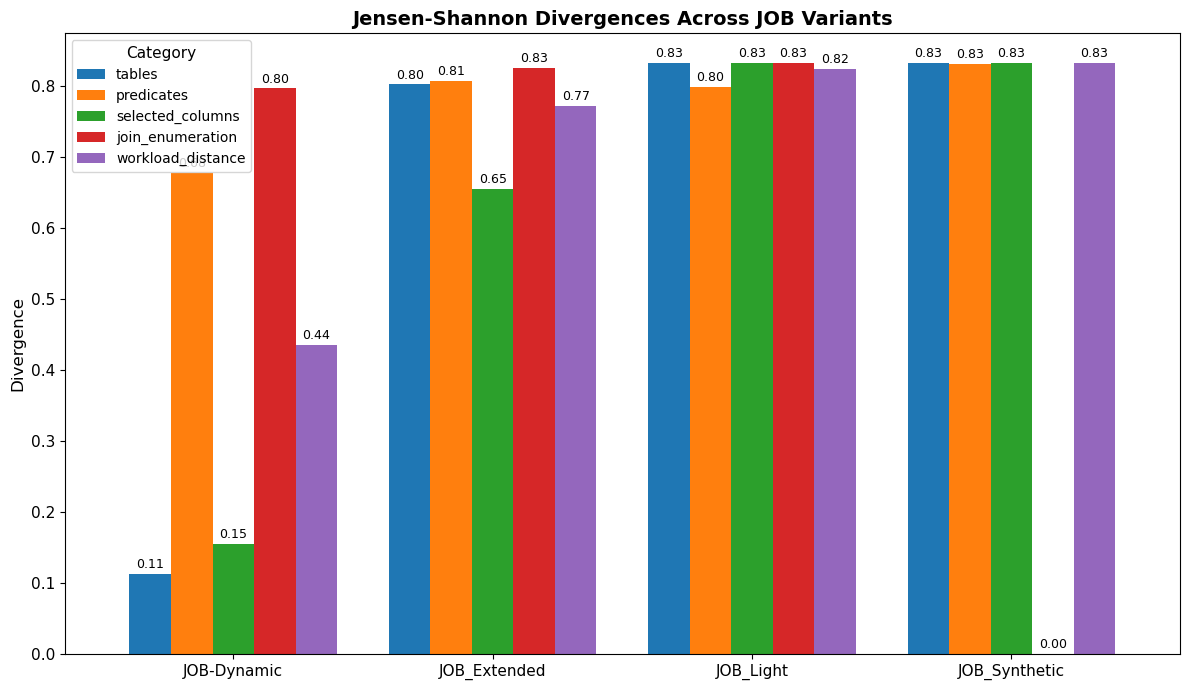

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
data = {
    "JOB-Dynamic": {
        "tables": 0.1126,
        "predicates": 0.6779,
        "selected_columns": 0.1549,
        "join_enumeration": 0.7968,
        "workload_distance": 0.4356,
    },
    "JOB_Extended": {
        "tables": 0.8024,
        "predicates": 0.8072,
        "selected_columns": 0.6548,
        "join_enumeration": 0.8255,
        "workload_distance": 0.7725,
    },
    "JOB_Light": {
        "tables": 0.8326,
        "predicates": 0.7986,
        "selected_columns": 0.8326,
        "join_enumeration": 0.8326,
        "workload_distance": 0.8241,
    },
    "JOB_Synthetic": {
        "tables": 0.8326,
        "predicates": 0.8315,
        "selected_columns": 0.8326,
        "join_enumeration": None,
        "workload_distance": None,  # will be calculated
    },
}

# Calculate workload_distance for JOB_Synthetic as the average of available values
synthetic_values = [
    data["JOB_Synthetic"]["tables"],
    data["JOB_Synthetic"]["predicates"],
    data["JOB_Synthetic"]["selected_columns"],
]
data["JOB_Synthetic"]["workload_distance"] = np.mean(synthetic_values)

# Convert to DataFrame
df_ = pd.DataFrame(data).T

# Plot
ax = df_.plot(kind="bar", figsize=(12, 7), width=0.8)
plt.title("Jensen-Shannon Divergences Across JOB Variants", fontsize=14, weight="bold")
plt.ylabel("Divergence", fontsize=12)
plt.xticks(rotation=0, ha="center", fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Category", fontsize=10, title_fontsize=11)

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge", padding=2)

plt.tight_layout()
plt.show()


In [7]:
# create_stacked_bar_plot(*prepare_data(df, 'unseen_queries', 'query_distribution'), title='Unseen Queries - Distribution')

### Takeaways

- **FASTgres**: more or less matches the perfromance of the classic optimizer across all workloads. 
  - This probably is tied to the fact that even during inference it develops a new decision tree for every new query context it encounters.

- **NEO**: shows massive slowdowns for job_extended and job_light, 2 workloads that have somewhat of a similar distribution, but performs less worse in the case of job_dynamic. Performs fine in the case of JOB-Synthetic
  - This means that the knowledge the model currently has leads it to catastrophic decisions for workloads like job_extended and job_light

- **LOGER**: has a slight degradation only in the case of *job_dynamic*, and major problems with all other workloads (that contain queries whose structure are significantly different than the JOB workload). 
  - This probably means that the Graph Transformer (a embedded neural network used for Query Encoding) struggles to transfer its knowledge on other workloads
  - In none of the cases however does it suffer from catastrophic decisions, since it's utility in the processing pipeline to restrict operators (rather than building a fully-fledged QEP from scratch)

- **BAO**: underperforms overall in all workloads with the exception of *job_light*
  - JOB-Light intuitively resembles a subset of JOB just with less complexity, as it reuses many of its joins and filters. So it is easier for BAO to reuse the hints it already learned cause of 

- **LERO**: Again, like NEO, LERO shows massive slowdowns for job_extended and job_light, 2 workloads that have somewhat of a similar distribution, but performs less worse in the case of job_dynamic. Performs fine in the case of JOB-Synthetic
  - The 2 optimizers share a Value Model so this is to be expected. The variation in performance across workloads also suggests that their slowdowns are not only an outcome of suboptimal learning, but also a product of bad generalization

---

### Query Complexity Generalization

We test the ability of the LOQs to generalize from simple to more complex queries

Train: JOB subset with queries < 10 joins

Test: JOB subset with queries > 10 joins

Preparing data for category: unseen_queries, subcategory: query_complexity


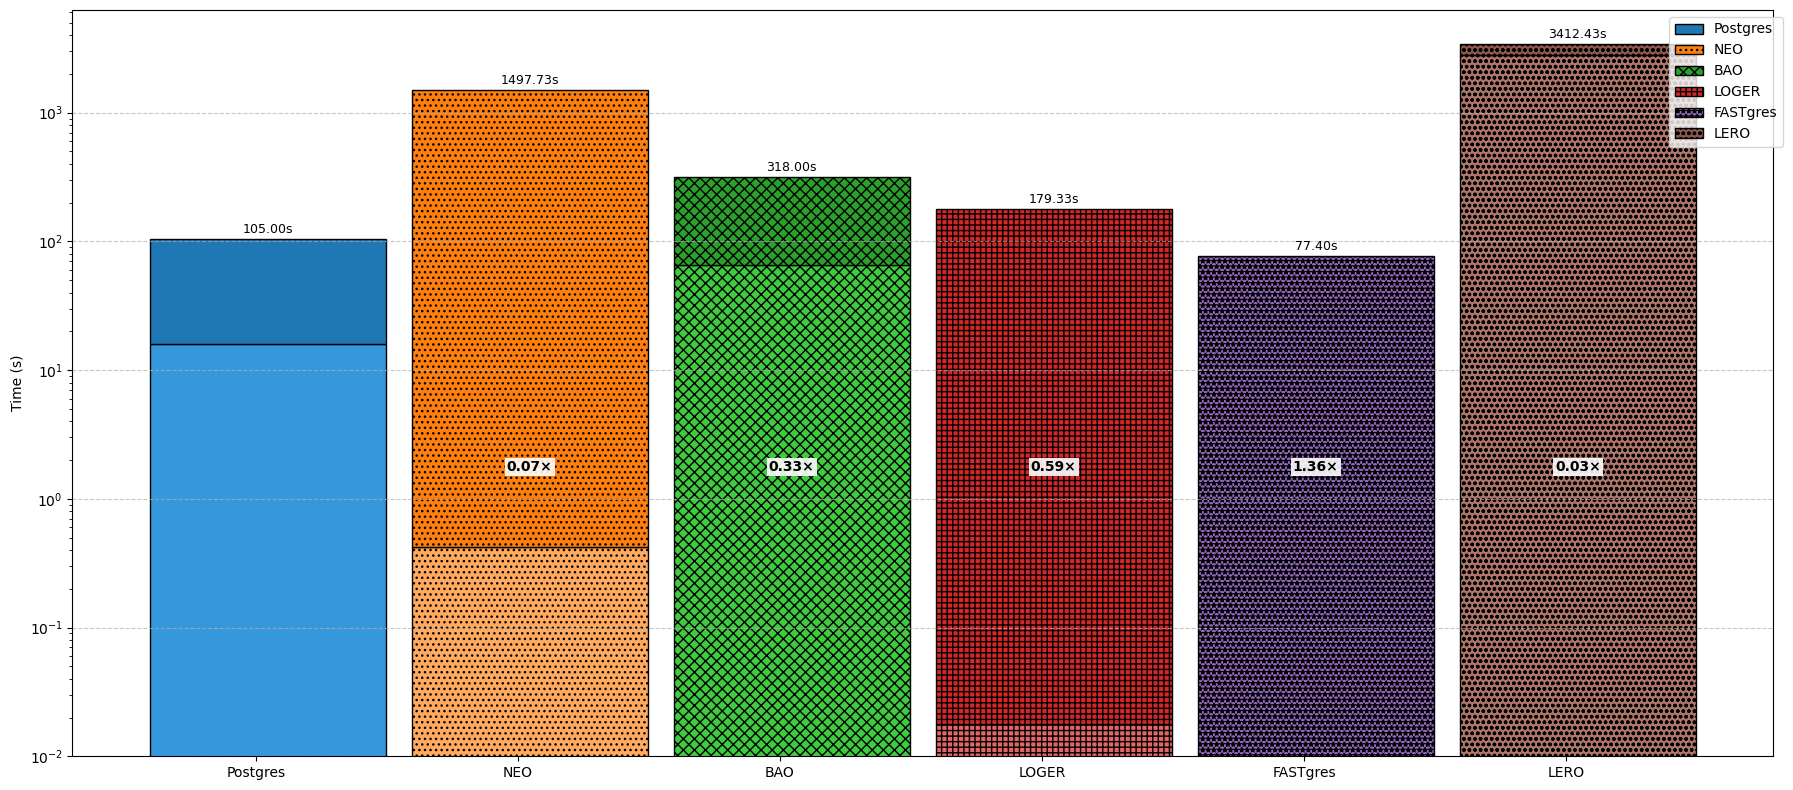

In [8]:
create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'unseen_queries', 'query_complexity'), title='Unseen Queries - Complexity')

### Takeaways

- **FASTgres**: Speedup over PostgreSQL
  - Again, this probably is because it develops a new decision tree for every new query context it encounters.
- **NEO, LERO**: Catastrophic decisions probably caused by the increased complexity. 
  - Their Tree-CNN value model learned a function to predict query latency, but this function is only valid for the simple query trees it saw during training.
- **LOGER**: has a slight degradation
  - Again, probably because the Graph Transformer can not transfer the knowledge
- **BAO**: The hints that were learned on the easier complexity did not generalize on the harder testing workload.

---

### Selectivity Generalization

We measure performance when query predicate selectivities are outside the range seen during training

Dataset: Subset of JOB-Synthetic and JOB-Extended, queries with title.production_year filters

Train: Predicates with low selectivity (∼0–20%)

Test: Predicates with high selectivity (∼60–100%)

Preparing data for category: unseen_queries, subcategory: query_selectivity


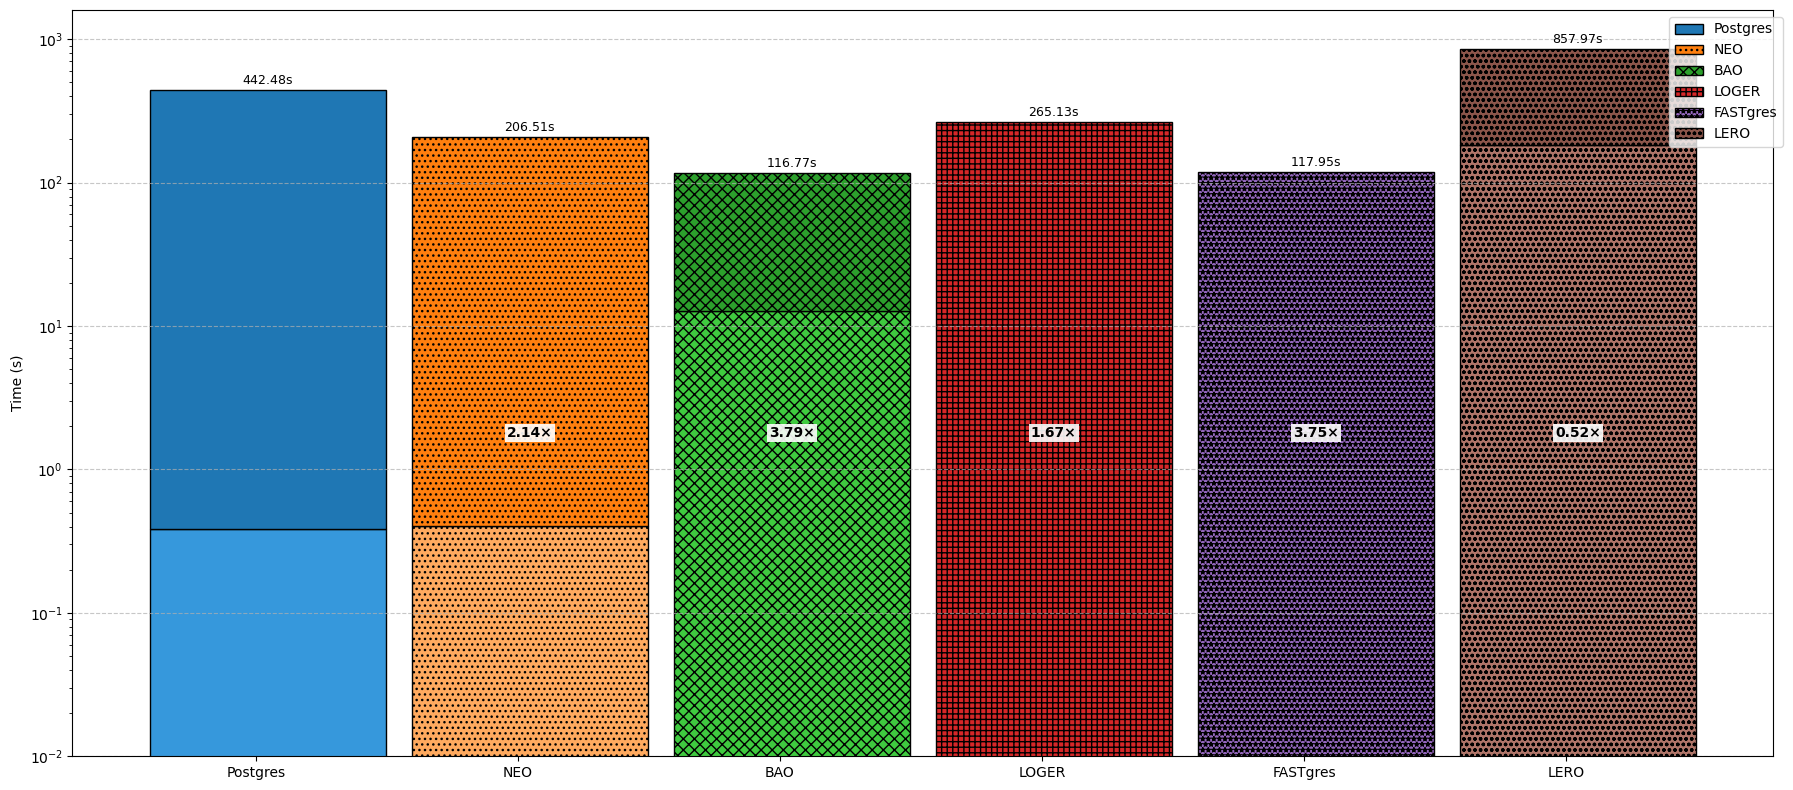

In [9]:
create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'unseen_queries', 'query_selectivity'), title='Unseen Queries - Selectivity')

### Takeaways

- **Postgres**: Struggled very much so, to the point that almost all other LQOs outperformed it. 
  - Probably proves the point about heuristics
- **FASTgres**: Significant speedup over PostgreSQL (3.75x)
- **BAO**: Also a significant speedup over PostgreSQL (3.79x). While BAO doesnt do Query encodings bao includes selectivity info per node on its plan encodings
- The hint-based optimizers showed by far the biggest speedups, suggesting that they learned a cost function relating selectivity to execution time. This probably ties in with the findings of experiment 4.1, where those optimizers where the ones that made drastic and unilateral deviations from the classic optimizer when it comes to scan operators
- **LOGER**: Uncharacteristically low speedup (1.67x, outperformed even by NEO with 2.14x), which again ties with the findings of 4.1 that said that LOGER when it comes to scan operators takes a sometimes conservative approach
  - Also, since the Graph Transormer is outright trained including selectivities in its featurization, the generalization of that knowledge is mayhaps done suboptimally
- **NEO**: Uncharacteristically good performance, appears to deal well with the relationship between selectivity and access path selection. Selectivity is inluded in query encodings so this is not totally unexpected
- **LERO**: Registers a slowdown of 0.5. 
  - It is probably the learning-to-rank paradigm that has overfit in this case, since the TCNN Value Model in the case of NEO appears to work just fine

---

## Adaptability to New Schemas

We evaluate how well optimizers adapt to changes in the database schema

### Workload-Specific Schema Shift

We examine the scenario where the database schema remains the same, however there is a shift in the workload where a table that was never looked up before is actually queried

Train: JOB workload excluding char_name queries

Test: JOB workload with only char_name queries

Preparing data for category: schema_shift, subcategory: workload_specific_schema_shift


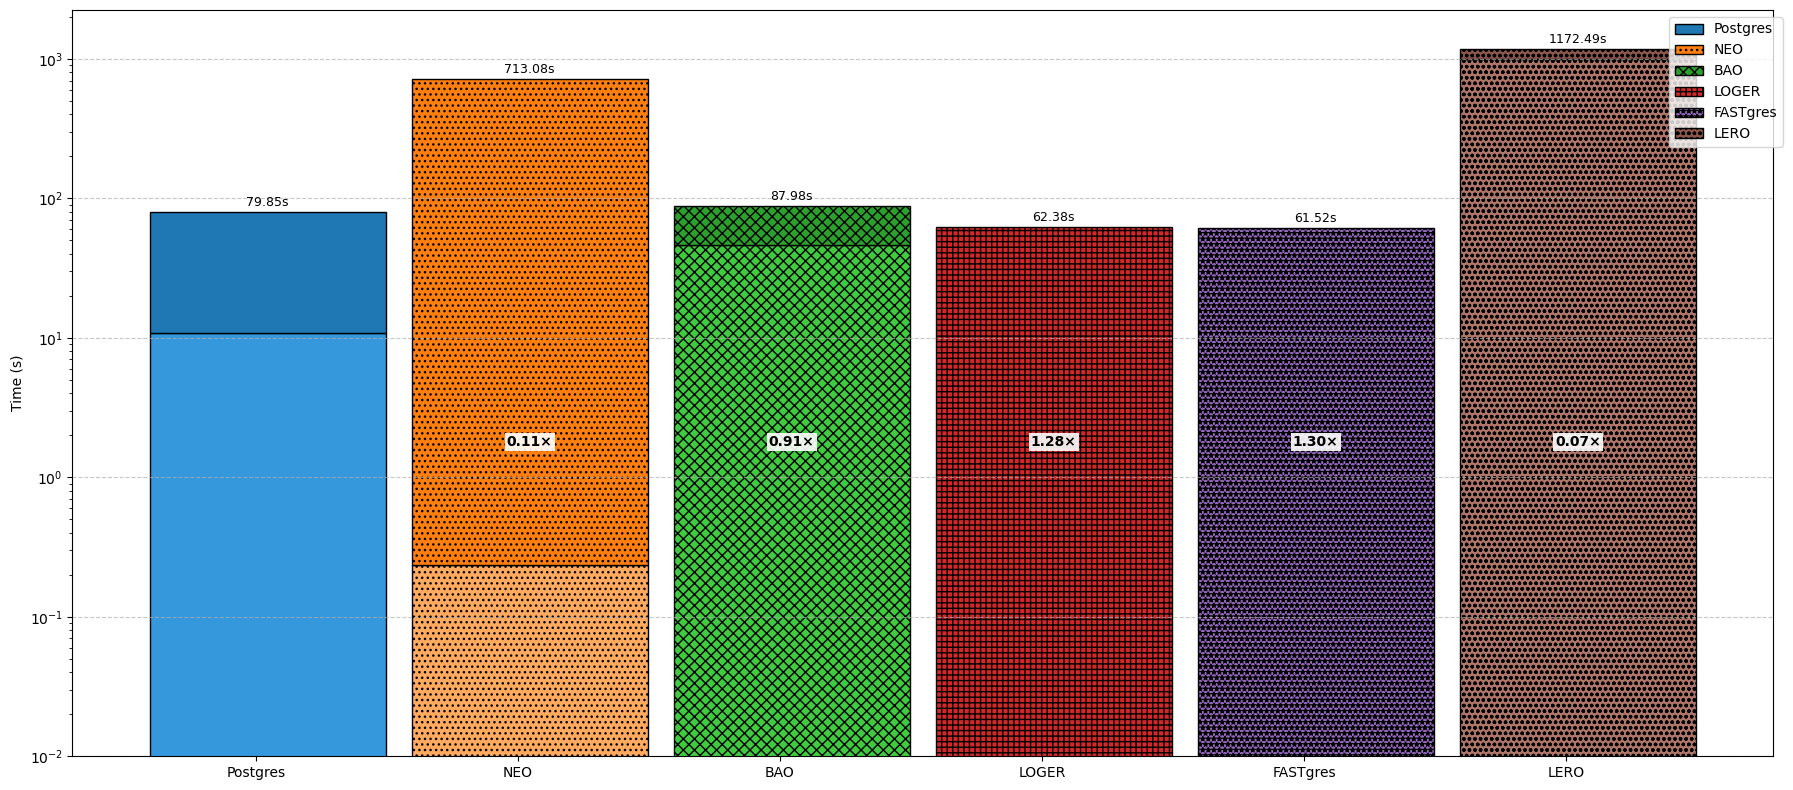

In [10]:
create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'schema_shift', 'workload_specific_schema_shift'), title='Schema Shift - Workload Specific')

### Takeaways

- **FASTgres** performs well, again probably due to its setup with the context models && the fact that it doesnt apply 1-Hot encoding of the tables in any encoding
- **LOGER** also performs well, the GT probably didnt have a problem understanding the new node on the join graph
- **BAO** avoids the schmea dependency by not using 1-Hot encodings, but still shows a minor slowdown
- **NEO** and **LERO** with catastrophic slowdowns, probably related to the fact that the use 1-Hot encodings in their plan encodings

### Database Schema Shift

Simulation of the scenario where a new table is included in the database

Train: SSB with the schema as is

Test: SSB with the fact table split into two tables (i.e. the original TPC-H design)

Preparing data for category: schema_shift, subcategory: structure_shift


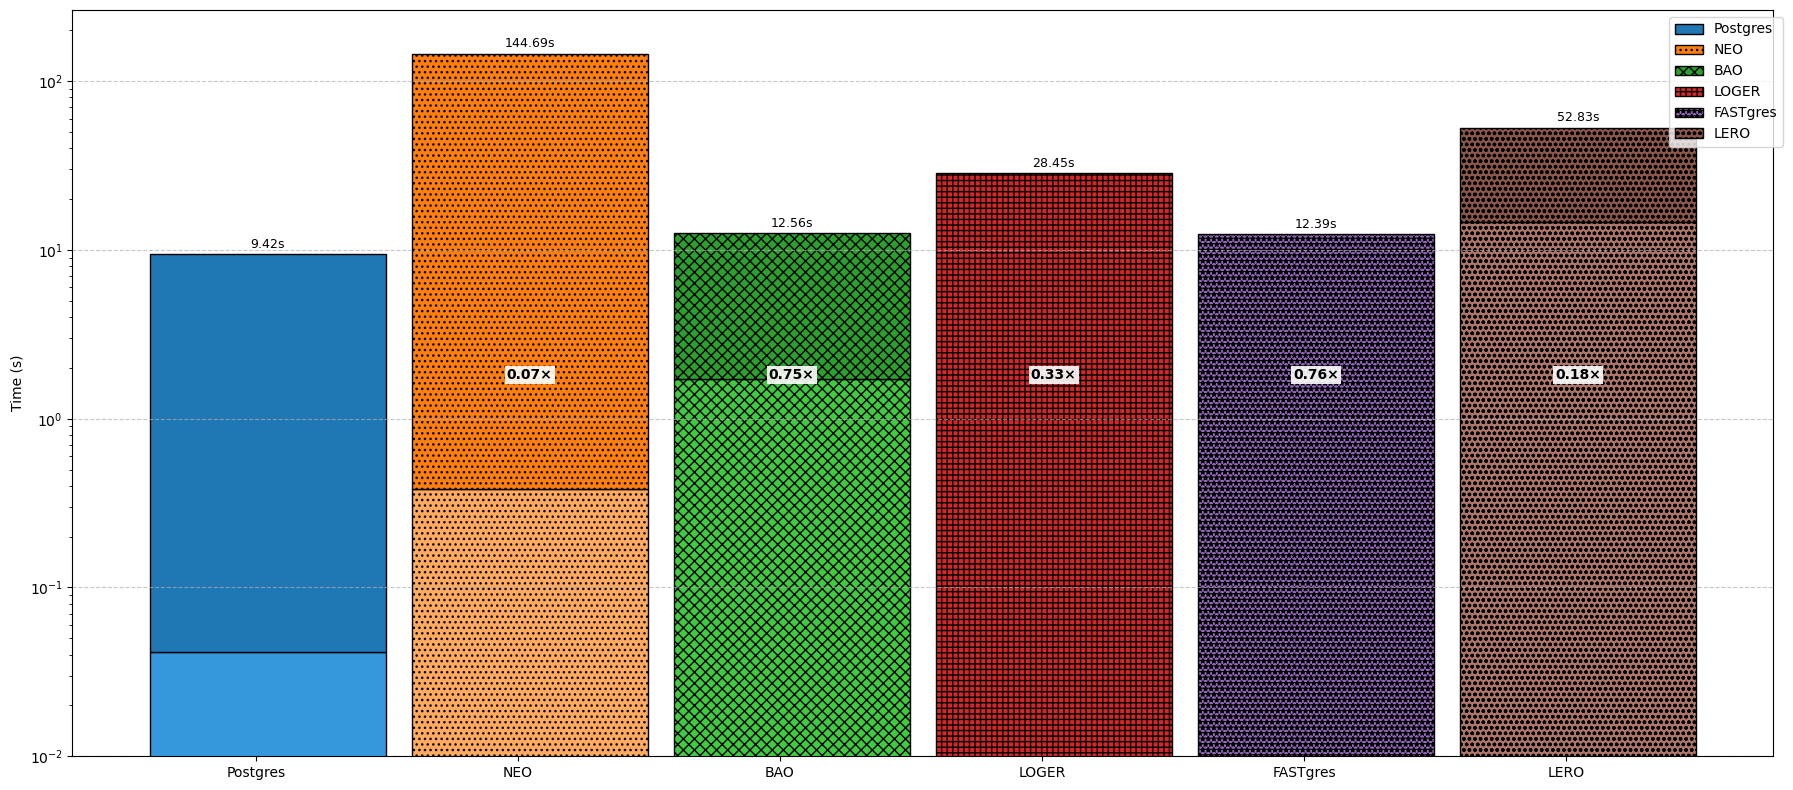

In [11]:
create_stacked_bar_plot_per_optimizer(*prepare_data(df, 'schema_shift', 'structure_shift'), title='Schema Shift - Structure Shift')

### Takeaways

**LOGER**: Significant slowdown
    - This time there is a major shift in the join graph, with the fact table being split into 2 dimension tables, which the GT model couldnt generalize to
    
**FASTgres**: performs well, again probably due to its setup with the context models && the fact that it doesnt apply 1-Hot encoding of the tables in any encoding *(same point as earlier)*

**BAO**: avoids the schmea dependency by not using 1-Hot encodings, but still shows a minor slowdown *(same point as earlier)*

**NEO**, **LERO**: same point as before, probably related to the fact that the use 1-Hot encodings in their plan encodings *(same point as earlier)*


---

## Adaptation to Data Distribution Shifts.

We assess the optimizer’s robustness to shifts in the underlying data distribution that occur as a database grows over time. 

Dataset: 3 STACK snapshots (1: 2008-2011, 2: 2008-2015, 3: 2008-2019)

Train: The 1st and 2nd snapshots

Test: For each test with train with a subset and test with a superset. This basically means we have two tests:
- 1st test: Train with 1, test with 2 and 3
- 2nd test: Train with 2, test with 3


----- Data Distribution Shift -----
Preparing data for category: data_distribution_shift, subcategory: None
Data Distribution Shift Latency Data (Cumulative Sums):
  Model Trained Year: 2015
    Evaluated Data Year: 2011 -> {'Postgres': np.float64(1055.763698)}
    Evaluated Data Year: 2015 -> {'Postgres': np.float64(74.01110499999999)}
    Evaluated Data Year: 2019 -> {'Postgres': np.float64(159.034564), 'NEO': np.float64(4680.195267000001), 'BAO': np.float64(333.30892900000003), 'LOGER': np.float64(8040.453825), 'FASTgres': np.float64(6060.315969)}
  Model Trained Year: 2011
    Evaluated Data Year: 2011 -> {'Postgres': np.float64(1055.763698)}
    Evaluated Data Year: 2015 -> {'Postgres': np.float64(74.01110499999999), 'NEO': np.float64(6410.35773), 'BAO': np.float64(317.917326), 'LOGER': np.float64(4798.121206999999), 'FASTgres': np.float64(18151.088947)}
    Evaluated Data Year: 2019 -> {'Postgres': np.float64(159.034564), 'NEO': np.float64(15226.510942), 'BAO': np.float64(386.86

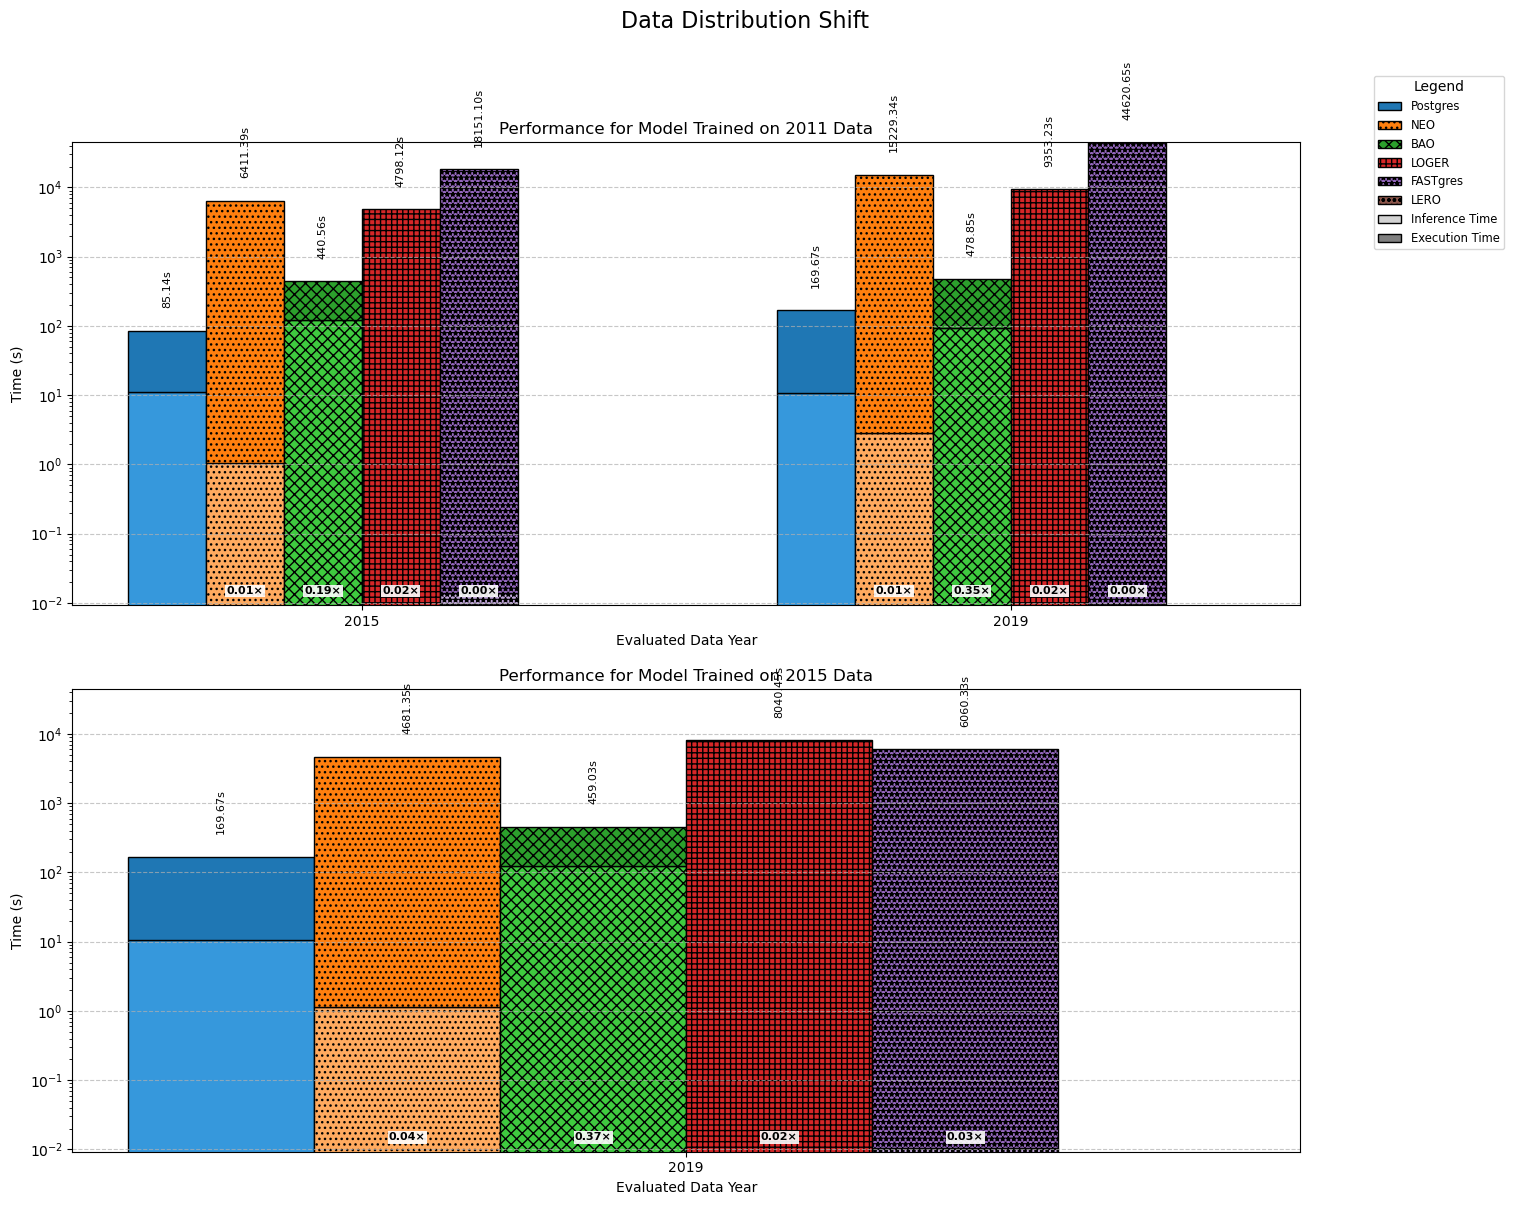

In [12]:
# Re-using from your previous code (for standard experiments)
def adjust_lightness(color, amount=0.5):
    try:
        c = colorsys.rgb_to_hls(*to_rgb(color))
        return to_hex(colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2]))
    except:
        return color

def create_stack_experiment_plot(latency_data, inference_data, title="Data Distribution Shift Performance", log_scale=True):
    base_colors = {
        'Postgres': '#1f77b4', 'NEO': '#ff7f0e', 'BAO': '#2ca02c',
        'LOGER': '#d62728', 'FASTgres': '#9467bd', 'LERO': '#8c564b'
    }
    patterns = {
        'Postgres': '', 'NEO': '...', 'BAO': 'xxx',
        'LOGER': '+++', 'FASTgres': '***', 'LERO': 'ooo'
    }

    # Get sorted list of model trained years to define subplots (excluding N/A)
    # These are the actual trained models (2011, 2015)
    model_trained_years_for_subplots = sorted([y for y in latency_data.keys() if y != 'N/A']) 

    if not model_trained_years_for_subplots:
        print("No data available to plot for Data Distribution Shift experiment after filtering N/A trained models.")
        return

    nrows = len(model_trained_years_for_subplots)
    fig, axs = plt.subplots(nrows, 1, figsize=(15, 6 * nrows), sharey=True, squeeze=False)
    
    bar_width = 0.12 # Width for each optimizer bar within a group
    
    # Prepare global legend handles (only once)
    optimizer_patches = [mpatches.Patch(facecolor=base_colors[o], edgecolor='black', hatch=patterns[o], label=o) for o in optimizers]
    exec_patch = mpatches.Patch(facecolor='gray', edgecolor='black', label='Execution Time')
    inf_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Inference Time')

    for row_idx, model_trained_year in enumerate(model_trained_years_for_subplots):
        ax = axs[row_idx, 0] # Get the current subplot axis
        
        current_latency_data_for_trained_year = latency_data[model_trained_year]
        current_inference_data_for_trained_year = inference_data[model_trained_year]
        
        # Define which evaluated_data_years are relevant for this model_trained_year
        relevant_evaluated_years = []
        if model_trained_year == '2011':
            relevant_evaluated_years = sorted([y for y in current_latency_data_for_trained_year.keys() if y in ['2015', '2019']])
        elif model_trained_year == '2015':
            relevant_evaluated_years = sorted([y for y in current_latency_data_for_trained_year.keys() if y == '2019'])
        
        if not relevant_evaluated_years:
            ax.set_title(f"Model Trained on {model_trained_year} Data (No relevant evaluation data)")
            ax.set_xticks([])
            ax.set_yticks([])
            continue # Skip plotting if no relevant evaluation data

        # Calculate x positions for groups of bars
        x_group_centers = np.arange(len(relevant_evaluated_years))
        num_optimizers_to_plot = len(optimizers) # All optimizers (including Postgres)
        
        # Calculate offsets for each optimizer within a group
        # The optimizers list is fixed for consistent offset calculation
        offset_per_optimizer = np.arange(num_optimizers_to_plot) - (num_optimizers_to_plot - 1) / 2
        
        for j, evaluated_data_year in enumerate(relevant_evaluated_years):
            group_x_pos = x_group_centers[j]

            # Retrieve Postgres baseline for this specific evaluated_data_year
            # Postgres data is already integrated into current_latency_data_for_trained_year
            pg_exec_for_eval = current_latency_data_for_trained_year[evaluated_data_year].get('Postgres', 0)
            pg_inf_for_eval = current_inference_data_for_trained_year[evaluated_data_year].get('Postgres', 0)
            pg_total_for_eval_year = pg_exec_for_eval + pg_inf_for_eval
            if pg_total_for_eval_year == 0: pg_total_for_eval_year = 1e-9 # Avoid division by zero

            for i, optimizer in enumerate(optimizers):
                exec_time = current_latency_data_for_trained_year[evaluated_data_year].get(optimizer, 0)
                inf_time = current_inference_data_for_trained_year[evaluated_data_year].get(optimizer, 0)
                total_time = exec_time + inf_time
                
                xpos = group_x_pos + offset_per_optimizer[i] * bar_width
                
                color = base_colors[optimizer]
                light_color = adjust_lightness(color, 1.3)
                hatch = patterns[optimizer]

                # Plot Inference Time
                ax.bar(xpos, inf_time, width=bar_width, color=light_color, edgecolor='black', hatch=hatch,
                       label='_nolegend_') # Labels handled by global legend

                # Plot Execution Time (stacked on inference time)
                ax.bar(xpos, exec_time, width=bar_width, bottom=inf_time, color=color, edgecolor='black', hatch=hatch,
                       label='_nolegend_') # Labels handled by global legend

                # Add total time text
                if total_time > 0:
                    text_y_offset = 0.02 * total_time if not log_scale else total_time * 1.1 # Adjust for log scale
                    ax.text(xpos, total_time + text_y_offset, f"{total_time:.2f}s",
                            ha='center', va='bottom', fontsize=8, rotation=90 if log_scale else 0)

                # Add speedup text relative to Postgres
                # This calculation now correctly uses the Postgres data available in the current_latency_data_for_trained_year dict
                if optimizer != 'Postgres' and total_time > 0:
                    speedup = pg_total_for_eval_year / total_time
                    # Position speedup text below the bar
                    # text_speedup_y_offset = ax.get_ylim()[0] * 1.5 if log_scale else -0.1 # Dynamic Y position for log scale
                    ax.text(
                        xpos, 0.02,  # 2% above x-axis, regardless of y scale
                        f"{speedup:.2f}×", ha='center', va='bottom',
                        fontsize=8, fontweight='bold', color='black',
                        bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.9),
                        transform=ax.get_xaxis_transform()
                    )
        
        # Set x-ticks and labels for the current subplot
        ax.set_xticks(x_group_centers)
        ax.set_xticklabels(relevant_evaluated_years)
        ax.set_xlabel("Evaluated Data Year")
        ax.set_ylabel("Time (s)")
        ax.set_title(f"Performance for Model Trained on {model_trained_year} Data")
        
        if log_scale:
            ax.set_yscale('log')
            ax.autoscale(enable=True, axis='y', tight=True)

        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Global Legend for optimizers and time components
    fig.legend(handles=optimizer_patches + [inf_patch, exec_patch], loc='upper right', bbox_to_anchor=(1.01, 0.95), title="Legend", fontsize='small')

    fig.suptitle(title, y=1.00, fontsize=16) # Main title above all subplots
    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for legend
    plt.show()
    # Also save the plot under the plots directory
    fig.savefig(f"plots/{title.replace(' ', '').lower()}.png", bbox_inches='tight')

print("\n----- Data Distribution Shift -----")
[latency_dict_dds, inference_dict_dds] = prepare_data(df, 'data_distribution_shift') # Subcategory 'stack'
if latency_dict_dds:
    print("Data Distribution Shift Latency Data (Cumulative Sums):")
    for model_year, eval_years_data in latency_dict_dds.items():
        print(f"  Model Trained Year: {model_year}")
        for eval_year, optim_data in eval_years_data.items():
            print(f"    Evaluated Data Year: {eval_year} -> {optim_data}")
    
    print("\nPlotting Data Distribution Shift results...")
    create_stack_experiment_plot(latency_dict_dds, inference_dict_dds, title='Data Distribution Shift')

### Takeaways

**FASTgres**: Struggled immensely with the new data distributions, since the context models it already knows are probably now giving very bad hints to the classic optimizer

**BAO**: Struggels with a similar problem but not as much, because bao incorporates live statistics from the database in its encoding